<a href="https://colab.research.google.com/github/Chu-Yichen/QM2-Group-19/blob/main/MAIN_Data_Collection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Read and merge monitoring station information and filter sites in Atlanta by distance**

In [4]:
!pip install haversine folium

import pandas as pd
import numpy as np
import haversine
import requests
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import math

monitors = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/aqs_monitors.zip', converters={'State Code': str, 'County Code': str, 'Site Number': str})
monitors['Site Id'] = monitors['State Code'] + '-' + monitors['County Code'] + '-' + monitors['Site Number']
# Creates a unique ID for each site
monitors = monitors[monitors['Parameter Code'].isin([81102, 88101, 44201, 42401, 42101, 42602])]
"""
Extracting monitors that contain our desired pollutants (PM10, PM2.5, Ozone, SO2, NO2, CO)
Ozone (O3 - ppm): 44201
PM2.5 (µg/m3): 88101
PM10 (µg/m3): 81102
CO (ppm): 42101
SO2 (ppb): 42401
NO2 (ppb): 42602
"""

monitors['First Year of Data'] = pd.to_numeric(monitors['First Year of Data'], errors='coerce')
monitors['Last Sample Date'] = pd.to_datetime(monitors['Last Sample Date'], errors='coerce')

# Extract the 'year' part of the Last Sample Date column
monitors['Last Year'] = monitors['Last Sample Date'].dt.year
monitors['Fist Year'] = monitors['First Year of Data']


"""
Counties in the Atlanta region (with their FIPS codes): https://atlantaregional.org/about-arc/about-the-atlanta-region/

Cherokee: 057
Clayton: 063
Cobb: 067
DeKalb: 089
Douglas: 097
Fayette: 113
Forsyth: 117
Fulton: 121
Gwinnett: 135
Henry: 151
Rockdale: 247
"""

# Filter the monitors, only leave those with 6 pollutants data available from 1999 to 2024.
atl_counties = ['057','063','067','089','097','113','117','121','135','151','247']
monitors = monitors[(monitors['State Code'] == '13') & (monitors['County Code'].isin(atl_counties))]


site_locations = monitors[['Site Id', 'Latitude', 'Longitude']]
# Filter the dataframe by Site ID and co-ordinates
site_locations = site_locations.drop_duplicates()
site_locations = site_locations.dropna()
# Creates unique rows for each site and removes any sites that do not contain Latitudes and Longitudes
site_locations = site_locations.set_index('Site Id')

def get_site_distances_km(site_locations, lat, lng):
    site_distances = {}
    for site_id, site_row in site_locations.iterrows():
        site_distances[site_id] = haversine.haversine((lat, lng), (site_row['Latitude'], site_row['Longitude']))
    return site_distances
# A function that finds the distance between inputted co-ordinates and each site. This returns a dictionary of site number and distance.

distances = get_site_distances_km(site_locations, 33.6324, -84.4333)
# Co-ordinates for Hartsfield-Jackson Atlanta International Airport into our function.

nearby_site_ids = [site_id for site_id, distance in distances.items() if distance < 15]
# This retrieves all of the site IDs within a 15km radius from the airport.
all_site_ids = set(site_locations.index.tolist()) - set(nearby_site_ids)
# All eligible sites in Atlanta, excluding those within a 15km radius.

# Print the results
print("Monitors within 15 km of Atlanta Airport:")
print(set(nearby_site_ids))
nearby_site_ids_lsit = list(nearby_site_ids)
print(monitors[monitors['Site Id'].isin(nearby_site_ids)][['Site Id', 'Parameter Code', 'Parameter Name', 'First Year of Data', 'Last Sample Date']].dropna().groupby(['Parameter Code', 'Parameter Name']).agg({'First Year of Data': 'min', 'Last Sample Date': 'max'}))

print("\nOther monitors within the specified counties and time range:")
print(set(all_site_ids))
all_site_ids_list = list(all_site_ids)
print(monitors[monitors['Site Id'].isin(all_site_ids)][['Site Id', 'Parameter Code', 'Parameter Name', 'First Year of Data', 'Last Sample Date']].dropna().groupby(['Parameter Code', 'Parameter Name']).agg({'First Year of Data': 'min', 'Last Sample Date': 'max'}))

<ipython-input-4-009f4ebe8824>:12: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  monitors = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/aqs_monitors.zip', converters={'State Code': str, 'County Code': str, 'Site Number': str})


Monitors within 15 km of Atlanta Airport:
{'13-121-5002', '13-121-0001', '13-121-0041', '13-121-5001', '13-121-0055', '13-121-0031', '13-121-0047', '13-121-1001', '13-121-0043', '13-063-0091', '13-089-0002', '13-121-0002', '13-121-0053', '13-121-4001'}
                                         First Year of Data Last Sample Date
Parameter Code Parameter Name                                               
42101          Carbon monoxide                       1972.0       2024-10-31
42401          Sulfur dioxide                        1962.0       2024-10-31
42602          Nitrogen dioxide (NO2)                1972.0       2024-08-31
44201          Ozone                                 1974.0       2024-08-31
81102          PM10 Total 0-10um STP                 1993.0       2024-09-30
88101          PM2.5 - Local Conditions              1999.0       2024-09-30

Other monitors within the specified counties and time range:
{'13-067-0004', '13-247-0001', '13-121-0042', '13-121-0050', '13-121-

<ipython-input-4-009f4ebe8824>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monitors['First Year of Data'] = pd.to_numeric(monitors['First Year of Data'], errors='coerce')
<ipython-input-4-009f4ebe8824>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monitors['Last Sample Date'] = pd.to_datetime(monitors['Last Sample Date'], errors='coerce')
<ipython-input-4-009f4ebe8824>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

# **Data Analysis for CO: (42101 Carbon Monoxide)**

Merge data

In [6]:
# 针对CO: Parameter Code 42101
# 我们需要 1999-2023 年，共25个URL
years = range(1999, 2025)  # 1999 ~ 2023
urls = [f"https://aqs.epa.gov/aqsweb/airdata/daily_42101_{year}.zip" for year in years]

# 将要筛选的目标站点 = nearby + all
target_sites = nearby_site_ids_lsit + all_site_ids_list

all_data = []
for url in urls:
    df = pd.read_csv(url, compression='zip', low_memory=False)
    # 统一格式
    df['State Code'] = df['State Code'].astype(str).str.zfill(2)
    df['County Code'] = df['County Code'].astype(str).str.zfill(3)
    df['Site Num'] = df['Site Num'].astype(str).str.zfill(4)
    df['Site Id'] = df['State Code'] + '-' + df['County Code'] + '-' + df['Site Num']
    df['Date Local'] = pd.to_datetime(df['Date Local'], errors='coerce')

    # 只保留目标站点
    df_target = df[df['Site Id'].isin(target_sites)]
    all_data.append(df_target)

# 合并所有年份
all_data = pd.concat(all_data, ignore_index=True)

# 分别拿到nearby和all的站点数据
df_nearby = all_data[all_data['Site Id'].isin(nearby_site_ids_lsit)].copy()
df_all = all_data[all_data['Site Id'].isin(all_site_ids_list)].copy()

# 提取每日均值：Arithmetic Mean
# 如果你的数据列名不同，请检查后改成相应列名
df_nearby_daily = df_nearby.groupby('Date Local')['Arithmetic Mean'].mean().reset_index(name='CO_mean_nearby')
df_all_daily = df_all.groupby('Date Local')['Arithmetic Mean'].mean().reset_index(name='CO_mean_all')



Visualisation: Daily Line Chart

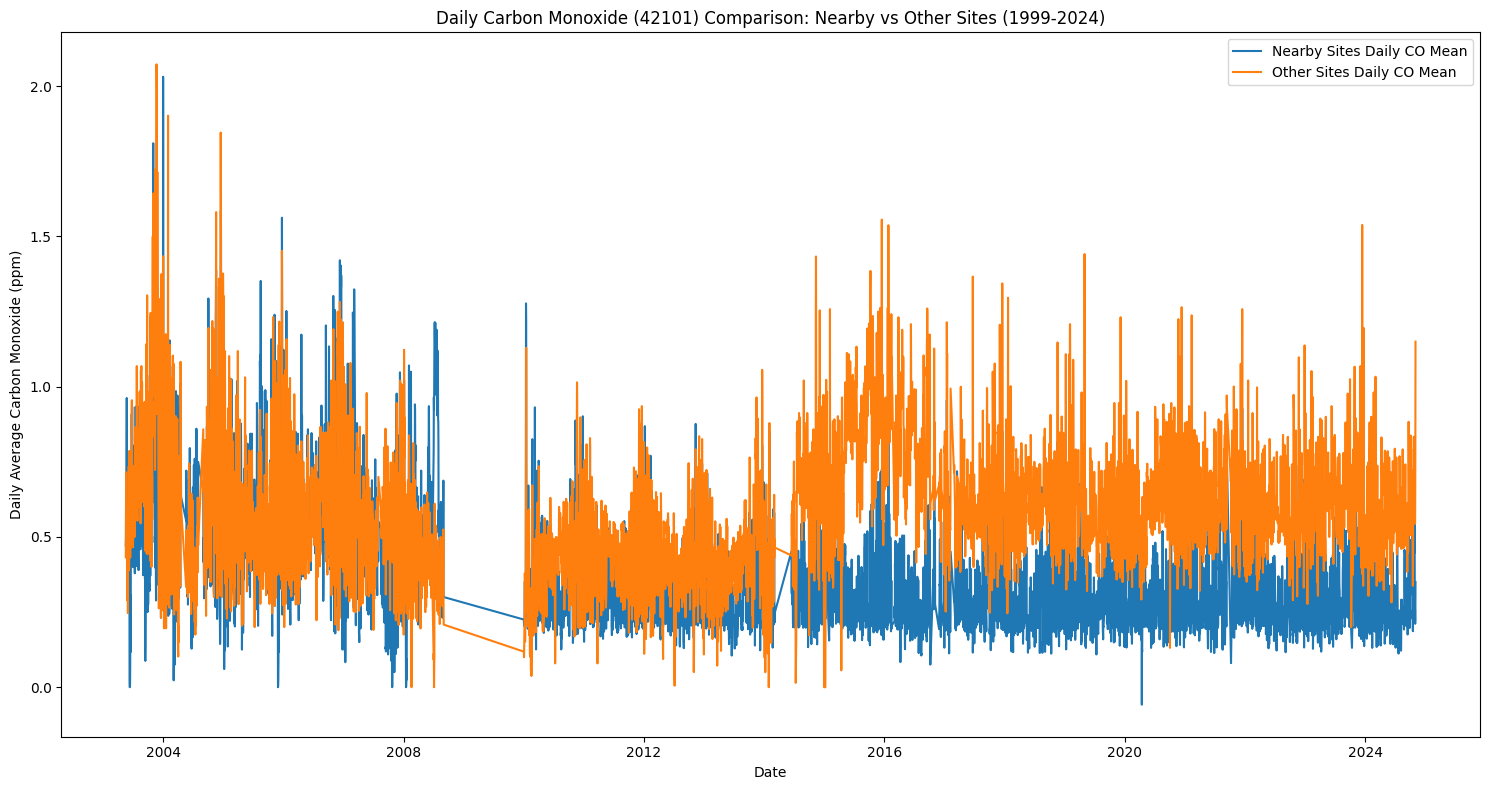

In [10]:
# 将两个 daily mean 合并，方便作图
df_plot_daily = pd.merge(df_nearby_daily, df_all_daily, on='Date Local', how='inner')

plt.figure(figsize=(15,8))
sns.lineplot(x='Date Local', y='CO_mean_nearby', data=df_plot_daily, label='Nearby Sites Daily CO Mean')
sns.lineplot(x='Date Local', y='CO_mean_all', data=df_plot_daily, label='Other Sites Daily CO Mean')
plt.title('Daily Carbon Monoxide (42101) Comparison: Nearby vs Other Sites (1999-2024)')
plt.xlabel('Date')
plt.ylabel('Daily Average Carbon Monoxide (ppm)')
plt.legend()
plt.tight_layout()
plt.show()


Visualisation: Annual Line Chart

Auual mean for nearby sites:     year  CO_mean_nearby
0   2003        0.619581
1   2004        0.539882
2   2005        0.552392
3   2006        0.584739
4   2007        0.454229
5   2008        0.535013
6   2010        0.345722
7   2011        0.331725
8   2012        0.330369
9   2013        0.297181
10  2014        0.312784
11  2015        0.312534
12  2016        0.288075
13  2017        0.314071
14  2018        0.274388
15  2019        0.299879
16  2020        0.287023
17  2021        0.309095
18  2022        0.295341
19  2023        0.309950
20  2024        0.288543

Annual mean for other sites in Atlanta     year  CO_mean_all
0   1999     0.788291
1   2000     0.667080
2   2001     0.726662
3   2002     0.639245
4   2003     0.703118
5   2004     0.612018
6   2005     0.594946
7   2006     0.612632
8   2007     0.540168
9   2008     0.402264
10  2009     0.384094
11  2010     0.402237
12  2011     0.434499
13  2012     0.426481
14  2013     0.427839
15  2014     0.569084
16  201

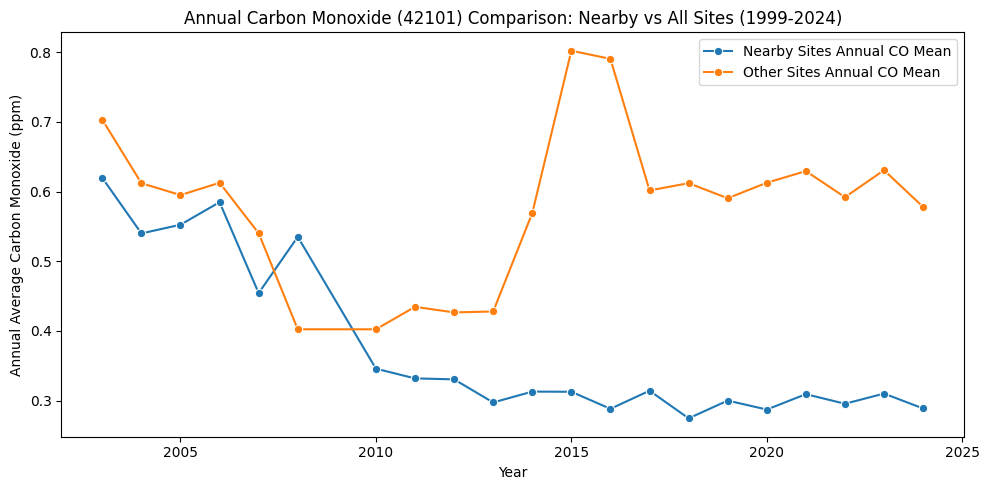

In [16]:
# 先给 daily 数据加一个 'year' 列
df_nearby_daily['year'] = df_nearby_daily['Date Local'].dt.year
df_all_daily['year'] = df_all_daily['Date Local'].dt.year

# 分组并取均值
df_nearby_annual = df_nearby_daily.groupby('year')['CO_mean_nearby'].mean().reset_index()
df_all_annual = df_all_daily.groupby('year')['CO_mean_all'].mean().reset_index()

print("Auual mean for nearby sites:",df_nearby_annual)
print("\nAnnual mean for other sites in Atlanta",df_all_annual) # Maybe looks a little bit messy but gives all the raw annual mean data

# 合并, 便于画图
df_plot_annual = pd.merge(df_nearby_annual, df_all_annual, on='year', how='inner')

plt.figure(figsize=(10,5))
sns.lineplot(x='year', y='CO_mean_nearby', data=df_plot_annual, marker='o', label='Nearby Sites Annual CO Mean')
sns.lineplot(x='year', y='CO_mean_all', data=df_plot_annual, marker='o', label='Other Sites Annual CO Mean')
plt.title('Annual Carbon Monoxide (42101) Comparison: Nearby vs All Sites (1999-2024)')
plt.xlabel('Year')
plt.ylabel('Annual Average Carbon Monoxide (ppm)')
plt.legend()
plt.tight_layout()
plt.show()


More Visualisation (Box Plot, Violin Plot)

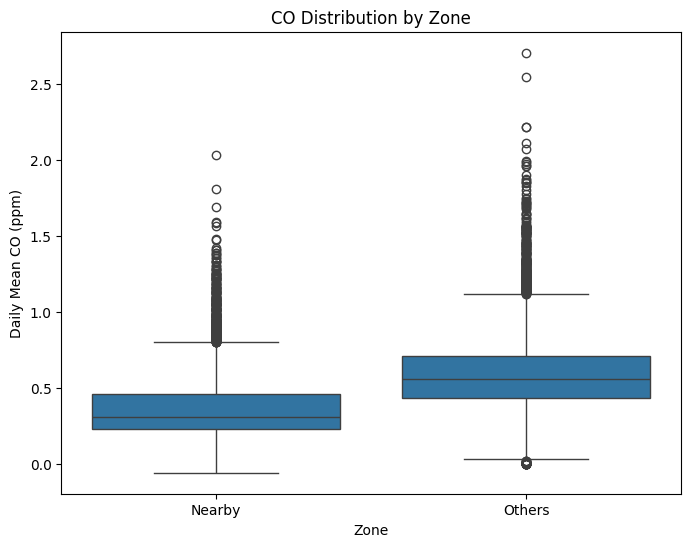

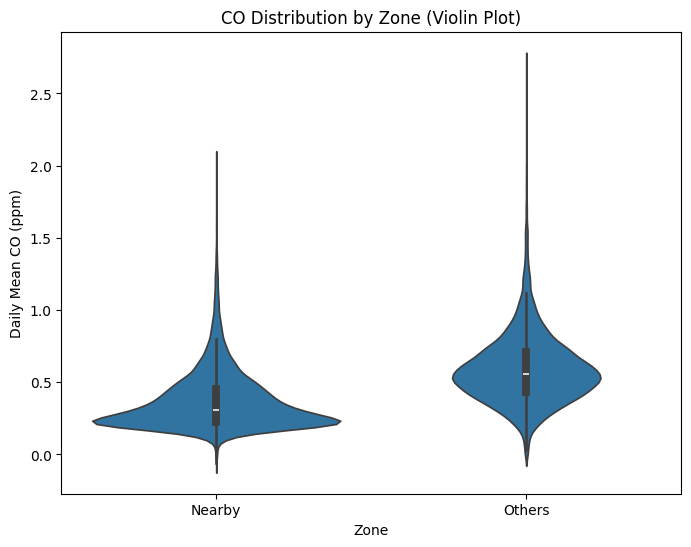

In [14]:
# 构造长格式数据，以便画图
df_nearby_long = df_nearby_daily[['Date Local', 'CO_mean_nearby']].rename(columns={'CO_mean_nearby': 'CO_mean'})
df_nearby_long['Zone'] = 'Nearby'

df_all_long = df_all_daily[['Date Local', 'CO_mean_all']].rename(columns={'CO_mean_all': 'CO_mean'})
df_all_long['Zone'] = 'Others'

df_daily_comparison = pd.concat([df_nearby_long, df_all_long], ignore_index=True)

# Box Plot
plt.figure(figsize=(8,6))
sns.boxplot(x='Zone', y='CO_mean', data=df_daily_comparison)
plt.title('CO Distribution by Zone')
plt.ylabel('Daily Mean CO (ppm)')
plt.show()

# 也可以尝试 Violin Plot
plt.figure(figsize=(8,6))
sns.violinplot(x='Zone', y='CO_mean', data=df_daily_comparison)
plt.title('CO Distribution by Zone (Violin Plot)')
plt.ylabel('Daily Mean CO (ppm)')
plt.show()


Interactive Map

In [13]:
import folium

# 以机场为中心
airport_lat, airport_lng = 33.6324, -84.4333
m = folium.Map(location=[airport_lat, airport_lng], zoom_start=9)

# 如果你有 site_locations DataFrame (Index=Site Id, Columns=['Latitude','Longitude'])
# 就可以遍历所有站点，把 near 和 all 区别标注颜色

for site_id, row in site_locations.iterrows():
    lat = row['Latitude']
    lng = row['Longitude']

    # 判断该站点属于 near 还是 all
    if site_id in nearby_site_ids_lsit:
        color = 'red'
        popup_text = f"[NEARBY] {site_id}"
    else:
        color = 'blue'
        popup_text = f"[ALL] {site_id}"

    folium.Marker(
        location=[lat, lng],
        popup=popup_text,
        icon=folium.Icon(color=color)
    ).add_to(m)

# 在 notebook 中直接显示地图：
m
